In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [107]:
def EV_PTF(S,mu,m):
    
    SI = np.linalg.inv(S)
   
    N = S.shape[0]

    C = mu @ SI @ mu

    one = np.ones(N)
    B = one @ SI @ mu
    A = one @ SI @ one

    Delta = A*C-B**2

    lmd = (C-m*B)/Delta

    gamma = (m*A-B)/Delta

    w = lmd*(SI @ one)+gamma*(SI @ mu)
    return w

def MaxSR_PTF(S,mu):
    Sinv = np.linalg.inv(S)
    N = S.shape[0]
    return (Sinv @ mu)/(np.ones(N) @ Sinv @ mu)

def Min_Var_PTF(S):
    w = np.linalg.pinv(S).sum(axis=1)
    return w/w.sum()


In [80]:
log_ret = pd.read_csv('russell1000_logret.csv',index_col=0)

In [81]:
# convert to vanilla
ret = np.exp(log_ret)-1

In [82]:
tin,tout = 2000,252

In [111]:
#1 year
Y = 252

In [83]:
# Select not null stocks
ret_sel = ret.iloc[:tin+tout]
ret_sel = ret_sel.T[(~ret_sel.isna()).all()].values

In [84]:
#in-sample, out-of-sample
ret_in, ret_out = ret_sel[:,:tin], ret_sel[:,tin:]

In [86]:
#Check for rendunant stocks
Cin = np.corrcoef(ret_in)

N = ret_in.shape[0]

indices = np.triu_indices(N,1)
#print top correlation coefficients
np.sort(Cin[indices])[::-1]

array([ 0.99769052,  0.85541589,  0.84051862, ..., -0.0835394 ,
       -0.08776943, -0.09141537])

In [87]:
#print lowest eigenvalues [they are very low]
np.sort(np.linalg.eigvalsh(Cin))[:4]

array([0.00145005, 0.09447289, 0.09814963, 0.09999806])

In [88]:
#remove one of this stocks with extraemly large correlation

index_to_remove = indices[0][Cin[indices].argmax()]

ret_in = np.delete(ret_in,index_to_remove,axis=0)
ret_out = np.delete(ret_out,index_to_remove,axis=0)

In [91]:
#Check again for rendunant stocks [the lowest eigenvalue disappears]
Cin = np.corrcoef(ret_in)

N = ret_in.shape[0]

indices = np.triu_indices(N,1)
np.sort(np.linalg.eigvalsh(Cin))[:4]

array([0.09443671, 0.0980896 , 0.09999674, 0.10400189])

In [92]:
#Compute in-sample and out-of-sample covariance and returns
Sin = np.cov(ret_in,bias=True)
Sout = np.cov(ret_out,bias=True)

mu_in = ret_in.mean(axis=1)
mu_out = ret_out.mean(axis=1)

In [104]:
#Compute maxSR PTF and Expecter return
w_sr = MaxSR_PTF(Sin,mu_in)

sr_ret_in = mu_in @ w_sr

In [105]:
#Compute minVar PTF and Expecter return
w_var = Min_Var_PTF(Sin)

var_ret_in = mu_in @ w_var

In [132]:
#Compute all PTF between minVar and maxSR
W = np.array([EV_PTF(Sin,mu_in,m) for m in np.linspace(var_ret_in,sr_ret_in,100)])

In [116]:
#Compute in-sample and out-of-sample frontier
Fin = np.array([(np.sqrt(Y * w @ Sin @ w ), Y*(mu_in @ w)) for w in W ])
Fout = np.array([(np.sqrt(Y * w @ Sout @ w ),  Y*(mu_out @ w)) for w in W ])

Text(0, 0.5, 'return')

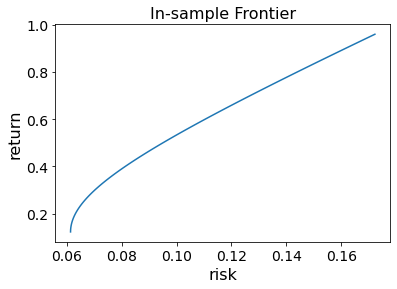

In [125]:
plt.plot(Fin[:,0],Fin[:,1])
plt.title('In-sample Frontier',fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel('risk',fontsize=16)
plt.ylabel('return',fontsize=16)

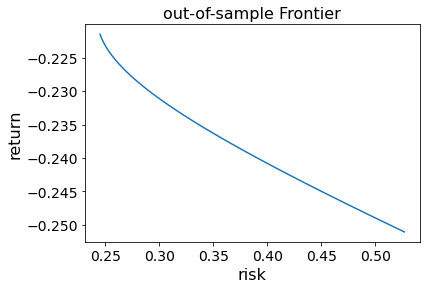

In [143]:
plt.plot(Fout[:,0],Fout[:,1])

plt.title('out-of-sample Frontier',fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel('risk',fontsize=16)
plt.ylabel('return',fontsize=16)
plt.show()

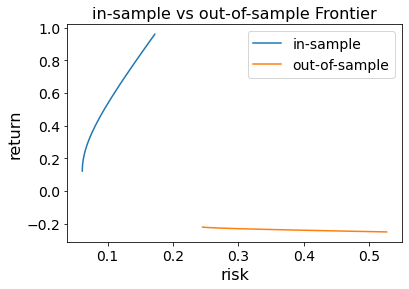

In [142]:
plt.plot(Fin[:,0],Fin[:,1],label='in-sample')
plt.plot(Fout[:,0],Fout[:,1],label='out-of-sample')

plt.title('in-sample vs out-of-sample Frontier',fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel('risk',fontsize=16)
plt.ylabel('return',fontsize=16)
plt.legend(loc='best',fontsize=14)
plt.show()

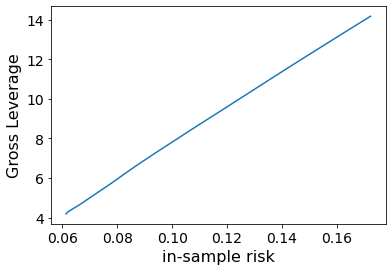

In [141]:
plt.plot(Fin[:,0],abs(W).sum(axis=1))

plt.tick_params(labelsize=14)
plt.xlabel('in-sample risk',fontsize=16)
plt.ylabel('Gross Leverage',fontsize=16)
plt.show()

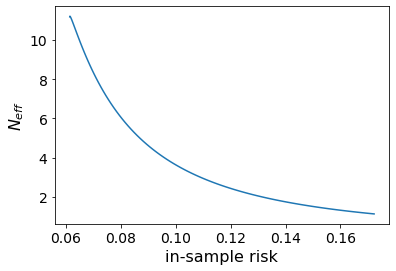

In [140]:
plt.plot(Fin[:,0],1/(W**2).sum(axis=1))

plt.tick_params(labelsize=14)
plt.xlabel('in-sample risk',fontsize=16)
plt.ylabel(r'$N_{eff}$',fontsize=16)
plt.show()

In [155]:
# Test different in-sample windows

In [198]:
OUT = []
for t in range(N+1,tin,5):
    ret_inx = ret_in[:,-t:]

    Sin = np.cov(ret_in[:,-t:],bias=True)
    
    lmin = np.linalg.eigvals(Sin).min()

    mu_in = ret_in.mean(axis=1)


    w = Min_Var_PTF(Sin)

    Neff = 1/(w**2).sum()
    G = abs(w).sum()
    risk_out = np.sqrt( Y * w @ Sout @ w )
    OUT.append((t,G,risk_out,lmin))

OUT = np.array(OUT)

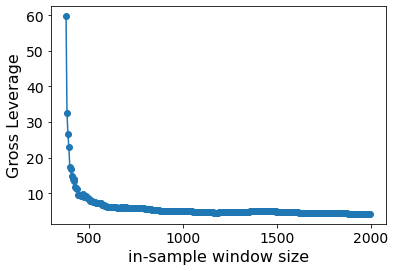

In [200]:
plt.plot(OUT[:,0],OUT[:,1],'-o')
plt.tick_params(labelsize=14)
plt.xlabel('in-sample window size',fontsize=16)
plt.ylabel('Gross Leverage',fontsize=16)
plt.show()

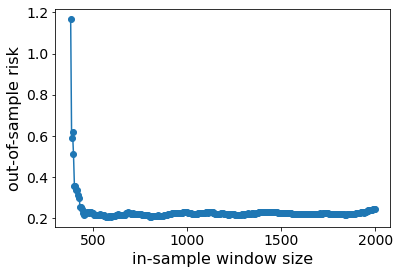

In [201]:
plt.plot(OUT[:,0],OUT[:,2],'-o')
plt.tick_params(labelsize=14)
plt.xlabel('in-sample window size',fontsize=16)
plt.ylabel(r'out-of-sample risk',fontsize=16)
plt.show()

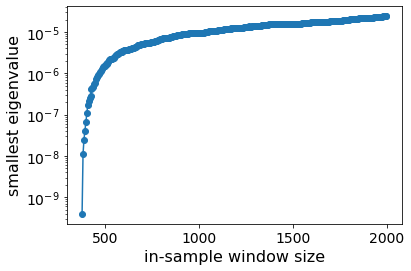

In [202]:
plt.plot(OUT[:,0],OUT[:,3],'-o')
plt.tick_params(labelsize=14)
plt.xlabel('in-sample window size',fontsize=16)
plt.ylabel(r'smallest eigenvalue',fontsize=16)
pltyscalecale('log')
plt.show()

In [ ]:
# LONG-ONLY constrains

In [210]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

In [211]:
def EV_PTF_positive(R,mu,m):

    N = R.shape[0]
    
    #Aw = b
    A = np.ones((2,N))
    A[1] = mu
    
    b = matrix(np.array([1.,m]))
    
    #G w < h
    G = -np.identity(N)
    h = matrix(np.zeros(N))


    A = matrix(A)
    G = matrix(G)
    
    # min w P w
    P = matrix(R)
    
    # min w q
    q = matrix(np.zeros(N))


    r = solvers.qp(P,q,A=A,b=b,G=G,h=h)
    
    return np.array(r['x']).T[0]

In [212]:
Sin = np.cov(ret_in,bias=True)
Sout = np.cov(ret_out,bias=True)

mu_in = ret_in.mean(axis=1)
mu_out = ret_out.mean(axis=1)

In [216]:
w = EV_PTF_positive(Sin,mu_in,0.001)

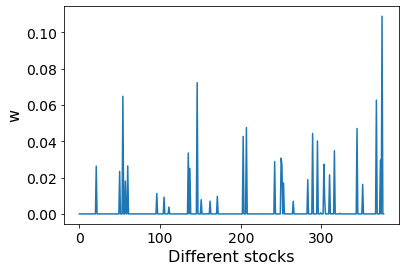

In [220]:
#weights
plt.plot(w)
plt.xlabel('Different stocks',fontsize=16)
plt.ylabel('w',fontsize=16)
plt.tick_params(labelsize=14)

In [ ]:
#IN-SAMPLE FRONTIER

In [238]:
W = np.array([EV_PTF_positive(Sin,mu_in,m) for m in np.linspace(0, 0.001,100)])

In [239]:
Fin = np.array([(np.sqrt(Y * w @ Sin @ w ), Y*(mu_in @ w)) for w in W ])

Text(0, 0.5, 'return')

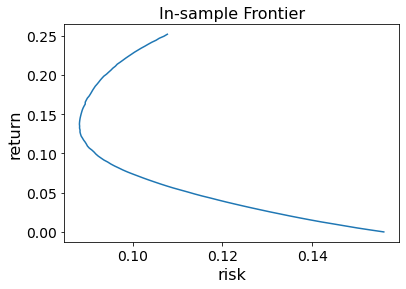

In [241]:
plt.plot(Fin[:,0],Fin[:,1])
plt.title('In-sample Frontier',fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel('risk',fontsize=16)
plt.ylabel('return',fontsize=16)